In [40]:
import pandas as pd
import numpy as np
from glob import glob
import keras
import os
import AngularGrid
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, concatenate, Concatenate
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def readFile(file):
  train = pd.read_csv(file)
  return train

def buildTrainXY(train_x, train_y):
  X_train, Y_train = [], []
  X_train = [[train_x.iloc[0]['pos_x'], train_x.iloc[0]['pos_y'], train_x.iloc[0]['vel_x'], train_x.iloc[0]['vel_y']]]
  y_lst = []
  for i in range(len(train_y)):
    # y_lst.append([train_y.iloc[i]['pos_x'], train_y.iloc[i]['pos_y'], train_y.iloc[i]['vel_x'], train_y.iloc[i]['vel_y']])
    y_lst.append(train_y.iloc[i]['pos_x'])
    y_lst.append(train_y.iloc[i]['pos_y'])
    y_lst.append(train_y.iloc[i]['vel_x'])
    y_lst.append(train_y.iloc[i]['vel_y'])
  Y_train.append([y_lst])
  
  Y_train = list(np.array(Y_train).flat)
  return X_train, Y_train

def buildTrainAG(train_ag):
  AG_train = [train_ag.iloc[0]]
  return AG_train

In [30]:
folder = "/home/linsea/motion_ws/src/motion_prediction/data/ETH_v1/"
i, testing_num = 1, 380
X_train ,Y_train , AG_train= [], [], []
X_test ,Y_test , AG_test= [], [], []

for file in glob(os.path.join(folder+'train_x/',"*.csv")):
  file_name = file.split('/')[-1]
  train_x = readFile(file)
  train_y = readFile(folder + 'train_y/' + file_name)
  train_ag = readFile(folder + 'train_ag/' + file_name)
  X, Y = buildTrainXY(train_x, train_y)
  AG = buildTrainAG(train_ag)
  if i > testing_num:
    X_train.append(X)       #ped_state
    Y_train.append(Y)       #ped_pred
    AG_train.append(AG)     #ag
  else:
    X_test.append(X)
    Y_test.append(Y)
    AG_test.append(AG)
  i+=1

X_train = np.array(X_train)
Y_train = np.array(Y_train)
AG_train = np.array(AG_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
AG_test = np.array(AG_test)


In [31]:
print('ped state shape:\t',X_train.shape)
print('ag shape:\t\t',AG_train.shape)
print('ped pred shape:\t\t',Y_train.shape)
print('\nped state test shape:\t',X_test.shape)
print('ag test shape:\t\t',AG_test.shape)
print('ped pred test shape:\t',Y_test.shape)

ped state shape:	 (720, 1, 4)
ag shape:		 (720, 1, 72)
ped pred shape:		 (720, 20)

ped state test shape:	 (380, 1, 4)
ag test shape:		 (380, 1, 72)
ped pred test shape:	 (380, 20)


In [32]:
ped_input = keras.Input(shape=( 1, 4), name= 'ped')
ped_features = LSTM(32)(ped_input)

ag_input = keras.Input(shape=( 1, 72), name= 'ag')
ag_features = Dense(128)(ag_input)
ag_features = LSTM(128)(ag_features)

x = concatenate([ ped_features, ag_features], axis=-1)
# feature = LSTM(160)(x)
feature = Dense(256, activation="relu")(x)
feature = Dense(128, activation="linear")(feature)

ped_pred = Dense(20, name='ped_pred')(x)

model = keras.Model(inputs = [ped_input, ag_input],
                    outputs = [ped_pred],
)
model.compile(
    optimizer = Adam(1e-3),
    loss=keras.losses.MeanSquaredError(),
)

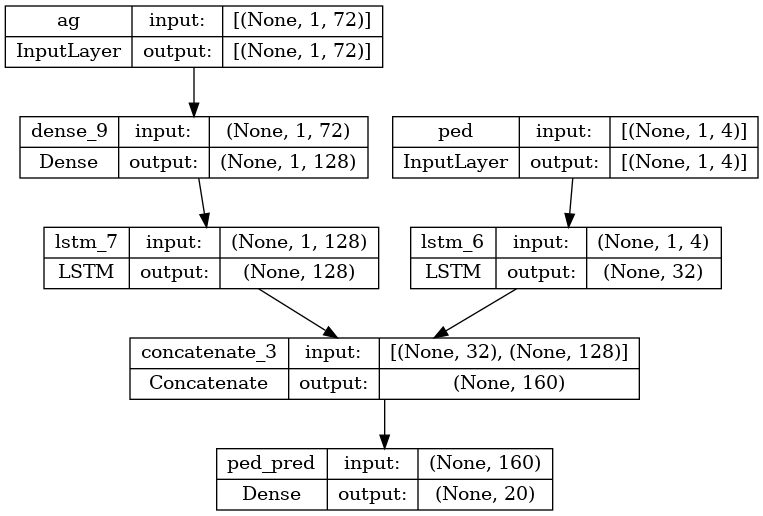

In [33]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [34]:
ped_data = X_train
ag_data = AG_train

ped_pred_data = Y_train

model.fit(
  {'ped': ped_data,'ag': ag_data},
  {'ped_pred': ped_pred_data},
  epochs = 50,
  batch_size = 16,
  validation_split=0.2,
)


Epoch 1/50
36/36 [==============================] - 2s 13ms/step - loss: 11.0892 - val_loss: 6.1459
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 5.9838 - val_loss: 5.5566
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 5.5323 - val_loss: 5.0663
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 4.8398 - val_loss: 4.2782
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 3.9478 - val_loss: 3.3392
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 3.0909 - val_loss: 2.5739
Epoch 7/50
36/36 [==============================] - 0s 3ms/step - loss: 2.4080 - val_loss: 1.9716
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 1.9171 - val_loss: 1.5635
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 1.5772 - val_loss: 1.3040
Epoch 10/50
36/36 [==============================] - 0s 3ms/step - loss: 1.3680 - val_loss: 1.1143
Epoch 11/50
36/36

In [35]:
preds_prob = model.predict([X_test, AG_test])
loss_metrics = model.evaluate([X_test, AG_test], Y_test)

12/12 [==============================] - 0s 1ms/step - loss: 0.1494


In [37]:
# print(preds_prob)
preds_prob = pd.DataFrame(preds_prob)
preds_prob

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.643934,2.741256,1.545485,0.438299,3.288755,2.932289,1.635284,0.379606,3.857413,2.969641,1.538252,0.257072,4.403612,3.089564,1.517111,0.244999,5.211180,3.208106,1.523834,0.138653
1,0.593034,5.898415,2.000440,-0.083976,1.402887,5.841272,1.981593,-0.125299,2.145067,5.773052,1.967777,-0.167206,2.794067,5.725390,1.882685,-0.121155,3.608563,5.825199,1.921224,-0.142022
2,-1.275815,1.577734,0.765922,0.749047,-0.925839,1.850870,0.859463,0.582994,-0.823452,1.771302,0.893278,0.506519,-0.380985,1.896261,0.963577,0.356179,-0.197179,2.163751,0.809305,0.424081
3,7.871502,8.704521,-0.031468,0.029889,7.969008,8.629365,0.051523,0.019425,7.740617,8.461521,-0.017837,-0.133429,7.942105,8.512663,-0.025760,-0.159531,7.721542,8.488976,-0.081718,-0.131762
4,7.870113,8.597054,-0.018016,0.000389,7.926368,8.513927,0.050718,0.015371,7.740222,8.365060,-0.027158,-0.124924,7.942389,8.391082,-0.015493,-0.151147,7.689868,8.377125,-0.079432,-0.122342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,10.090057,5.442519,0.977968,-0.121062,10.522001,5.350241,0.944842,-0.193735,10.816010,5.376336,0.932945,-0.231093,11.240134,5.300058,0.864882,-0.186499,11.386021,5.293746,0.823649,-0.191642
376,6.748822,6.351979,1.536259,-0.385380,7.385100,6.214059,1.451886,-0.394672,7.824347,6.195918,1.499845,-0.465707,8.519901,6.136240,1.487495,-0.441435,8.904799,5.924068,1.429820,-0.410620
377,3.249404,4.831940,-1.629067,-0.116716,2.771347,4.761626,-1.647973,-0.191408,1.966940,4.758857,-1.677886,-0.288981,1.337869,4.658426,-1.632156,-0.283477,0.741795,4.605628,-1.650623,-0.349934
378,1.553242,2.134510,-1.470360,-0.434666,1.033852,1.987144,-1.479971,-0.407830,0.402987,1.918245,-1.472687,-0.586252,-0.081366,1.679969,-1.430647,-0.549716,-0.777206,1.566827,-1.512094,-0.605840


In [38]:
Y_test = pd.DataFrame(Y_test)
Y_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.678267,2.521993,1.563625,0.500204,3.376558,2.787563,1.603623,0.548463,3.961165,2.960764,1.442948,0.320213,4.530917,3.043733,1.416975,0.260115,5.094745,3.168855,1.455340,0.309697
1,0.434964,6.100050,1.931539,-0.092025,1.053227,6.161285,1.587377,0.037736,1.704865,6.130238,1.681102,-0.024806,2.398109,6.141439,1.781737,0.079394,3.130254,6.193753,1.746980,0.024367
2,-4.558934,-0.031151,1.131696,1.089052,-4.111535,0.376757,1.111587,1.013470,-3.669665,0.779625,1.370243,0.883253,-3.015341,1.083359,1.488159,0.811711,-2.479137,1.428994,1.547262,0.978593
3,8.093101,8.835435,0.000000,0.000000,8.093101,8.835435,0.000000,0.000000,8.093101,8.835435,0.000000,0.000000,8.093101,8.835435,0.000000,0.000000,8.093101,8.835435,0.000000,0.000000
4,8.093101,8.835435,0.000000,0.000000,8.093101,8.835435,0.000000,0.000000,8.093101,8.835435,0.000000,0.000000,8.093101,8.835435,0.000000,0.000000,8.093101,8.835435,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,9.285382,5.324304,0.860982,-0.137363,9.650428,5.309163,1.107322,-0.045927,10.171240,5.287562,1.100369,0.053813,10.530723,5.352214,1.029926,-0.092135,10.995181,5.213854,1.301388,-0.251467
376,6.623388,6.230522,1.406337,-0.334823,7.183048,6.118387,1.381004,-0.432510,7.728191,5.884514,1.413791,-0.429950,8.314081,5.774427,1.451089,-0.323794,8.889062,5.625478,1.373715,-0.417763
377,3.317633,4.736865,-1.745772,-0.057445,2.586006,4.670439,-1.780531,-0.113454,1.893209,4.646102,-1.747575,-0.061391,1.187945,4.621326,-1.783691,-0.119526,0.466256,4.550481,-1.750822,-0.122952
378,1.594806,1.976652,-1.677470,-0.521452,0.919497,1.789070,-1.591562,-0.705078,0.321557,1.412589,-1.285672,-0.652464,-0.109040,1.267098,-1.436556,-0.607842,-0.827688,0.926316,-1.546511,-0.914366


In [39]:
# preds_prob = pd.DataFrame(preds_prob)
preds_prob.shape[1]

20

In [58]:
def get_ADE_FDE(pred, test, pred_time):
  ade, fde = 0, 0

  for i in range(len(pred)):
    individual_ade, individual_fde = 0, 0
    pred_info = pred.iloc[i]
    test_info = test.iloc[i]
    t = 0
  
    for p in range(0, pred.shape[1],4):
      t += 1
      pred_pos = AngularGrid.pt(pred_info[p], pred_info[p+1])
      test_pos = AngularGrid.pt(test_info[p], test_info[p+1])
      dist = AngularGrid.pt.distance(pred_pos, test_pos)
      individual_ade += dist
      if t == pred_time:
        individual_fde += dist
      else:
        pass
    individual_ade = individual_ade / pred_time
    # print('ade = ', individual_ade,'\nfde = ', individual_fde)
    ade += individual_ade
    fde += individual_fde
  ade = ade / len(pred)
  fde = fde / len(pred)
  return np.round(ade, 6), np.round(fde, 6)

ade, fde = get_ADE_FDE(preds_prob, Y_test, 5)
# print('ade = ', ade,'\nfde = ', fde)

    
      


ade =  0.1507 
fde =  0.1229
ade =  0.49505999999999994 
fde =  0.6038
ade =  3.0668999999999995 
fde =  2.3973
ade =  0.37522 
fde =  0.508
ade =  0.47124000000000005 
fde =  0.6104
ade =  0.20936 
fde =  0.162
ade =  0.71884 
fde =  1.0878
ade =  0.38196 
fde =  0.4468
ade =  0.25032 
fde =  0.222
ade =  0.22978 
fde =  0.3511
ade =  0.20600000000000002 
fde =  0.1461
ade =  0.22315999999999997 
fde =  0.2485
ade =  0.13520000000000001 
fde =  0.1711
ade =  0.30808 
fde =  0.3382
ade =  0.7429 
fde =  0.819
ade =  0.329 
fde =  0.3189
ade =  0.19945999999999997 
fde =  0.2887
ade =  0.22668 
fde =  0.0173
ade =  1.24398 
fde =  1.5576
ade =  3.36678 
fde =  3.6347
ade =  0.7594200000000001 
fde =  1.3478
ade =  0.7308599999999998 
fde =  0.7684
ade =  0.5605 
fde =  0.9574
ade =  0.42438000000000003 
fde =  0.4128
ade =  0.6766599999999999 
fde =  0.5653
ade =  0.57098 
fde =  0.7595
ade =  1.1415199999999999 
fde =  1.063
ade =  0.30196 
fde =  0.304
ade =  0.30256000000000005 
fde 

In [31]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = keras.layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = keras.layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = keras.layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)
